# Kalman Filters

Can help for Local Localization where the start location is known.

Makes some very strong assumptions about the underlying processes. Namely

* Assumes dynamics are linear.
* Assumes dynamics noise is additive and gaussian.
* Assumes observation noise is additive and gaussian.

Linearity can be relaxed by making local linear approximates to non-linear dynamics. But if this just won't do, or the noise must be arbitrary, consider other strategies, for eg. use Particle Filters in Monte-Carlo Localization.

In [0]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(1200)

## 1d Kalman Filter

* Assume dynamics are linear and 1d

### Define Kalman Filter and related funcs

In [0]:
def newton_state_update(curr_loc, vel, step, dt=1.0):
  """Moves system forward based on perfect noiseless newtonian dynamics"""
  return curr_loc + vel*step*dt

def noisy_state_update(curr_loc, curr_sig, vel_mu, vel_sig, dt=1.0):
  """Predicts next state using noisy state dynamics"""
  # Prediction for new mean from dynamics model
  # The gaussian error is our model of how noise will really affect the true
  # velocity. Think skidding etc. We really stand by it, and will actually 
  # incorporate it into the dynamics laws.
  next_loc = curr_loc + vel_mu*dt + np.sqrt(vel_sig)*np.random.randn()
  # Prediction for new variance from dynamics model
  next_sig = curr_sig + vel_sig
  # Return predicitions
  return (next_loc, next_sig)

def measurement_update(loc, sig, measured_loc, measurement_sig):
  """Updates loc and sig based on measured values"""
  # Some zero checking so denominator is not zero
  if np.isclose(sig, 0.0):
    sig = 1e-7
  elif np.isclose(measurement_sig, 0.0):
    measurement_sig = 1e-7
  # Location should be weighted mean of dynamics and measured values
  corrected_loc = (measurement_sig*loc + sig*measured_loc)/(sig + measurement_sig)
  # Variance should be a kind of harmonic mean of the dynamics and measurement variances.
  corrected_sig = sig*measurement_sig/(sig + measurement_sig)
  return (corrected_loc, corrected_sig)

def kalman_1d(loc, sig, measured_loc, measurement_sig, vel_mu, vel_sig, dt=1.0):
  """Correct loc, sig with measurements and make a new prediction from noisy dynamics"""
  # Correct state estimate with measurement
  corrected_loc, corrected_sig = measurement_update(loc, sig, measured_loc, measurement_sig)
  # Predict next state from current state estimate
  next_loc, next_sig = noisy_state_update(corrected_loc, corrected_sig, vel_mu, vel_sig, dt)
  return corrected_loc, corrected_sig, next_loc, next_sig

def kalman_1d_sim(init_loc_est, init_sig_est, actual_init_loc, vel_mu, vel_sig, measurement_sig, dt=1.0, N=20):
  """Simulate a 1d linear robot for N steps using a Kalman Filter"""
  measured_locs_perfect = np.zeros(N)
  measured_locs = np.zeros(N)
  corrected_locs = np.zeros(N)
  corrected_sigs = np.zeros(N)
  loc = init_loc_est
  sig = init_sig_est
  for i in range(N):
    # Make noisy measurement
    measured_loc_perfect = newton_state_update(actual_init_loc, vel_mu, i, dt)
    measured_loc = measured_loc_perfect + np.sqrt(measurement_sig)*np.random.randn()
    # Run kalman filter to correct prediction with measurement
    corrected_loc, corrected_sig, loc, sig = kalman_1d(loc, sig, measured_loc, measurement_sig, vel_mu, vel_sig, dt)
    # Store for output
    measured_locs_perfect[i] = measured_loc_perfect
    measured_locs[i] = measured_loc
    corrected_locs[i] = corrected_loc
    corrected_sigs[i] = corrected_sig
  return measured_locs_perfect, measured_locs, corrected_locs, corrected_sigs

### Set vars and run the 1d filter

In [0]:
# Initial state, known because we only deal with Local Localization. Naive would start here and be way off.
init_loc_est = 30
init_sig_est = 10

# Time step
dt = 1.0

# Number of motions/measurements
N = 100

# Actual Start. Never directly used in dynamics, only through measurements.
actual_init_loc = -5

# Velocity values for noisy dynamics update. I've kept vel_sig small.
vel_sig = 0.1
vel_mu = 0.1

# Measurements. I've made it very noisy.
measurement_sig = 20

# Do 1d Kalman Sim
measured_locs_perfect, measured_locs, corrected_locs, corrected_sigs = kalman_1d_sim(init_loc_est, init_sig_est, actual_init_loc, vel_mu, vel_sig, measurement_sig, dt, N)

### Graph perfect and measured locations

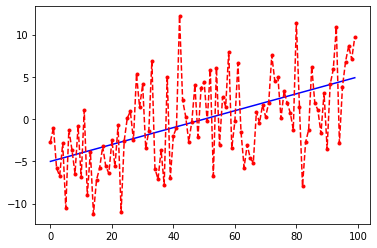

In [4]:
plt.plot(measured_locs_perfect, 'b')
plt.plot(measured_locs, 'r.--')

### Graph perfect, measured and Kalman Filtered locations

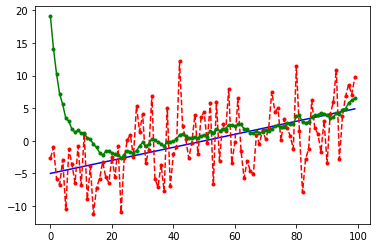

In [5]:
plt.plot(measured_locs_perfect, 'b')
plt.plot(measured_locs, 'r.--')
plt.plot(corrected_locs, 'g.-')

### Graph esimated variance

I don't really know how to make much sense of this other than it's good it's dropping, which means over time we are getting more confident.

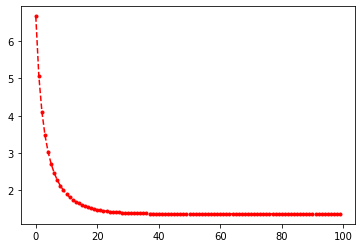

In [6]:
plt.plot(corrected_sigs, 'r.--')

In [7]:
corrected_sigs[-1]

1.3650987075002659